In [2]:
# Custom CNN Model
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Linear model (width*height*channel of the last feature map, Number of class)
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        flatten = out.view(out.size(0), -1)  # Flatten
        # flatten = out.reshape(out.size(0), -1) # We can also use '.reshape'
        score = self.fc(flatten) # Score
        # prob = F.softmax(score) 
        '''If you use 'torch.nn.CrossEntropyLoss', you don't need to add 'F.softmax'.'''
        '''Basically 'torch.nn.CrossEntropyLoss' contains log softmax'''
        return score

In [4]:
model = ConvNet()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [8]:
# Predefined Model
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(weights=None)
num_classes = 10
model.fc = nn.Linear(512, num_classes)

In [ ]:
print(model)

In [9]:
import torch.optim as optim

learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [28]:
# Dataset

from torchvision import datasets
from torchvision.transforms import ToTensor

root = '/home/yunjae_heo/workspace/ailab_mat/datasets/cifar10'
# root = "./data"

train_data = datasets.CIFAR10(
    root=root, # 불러올 데이터가 있는 path
    train=True, # train data를 불러올거면 True, test data를 불러올거면 False
    download=True, # 데이터가 존재하지 않으면 root에 해당 데이터셋을 다운로드
    transform=ToTensor() # dataset에 적용할 transform 지정
)
test_data = datasets.CIFAR10(
    root=root,
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# dimension order in torch : (channel, height, width)
print(train_data[0][0].shape)

torch.Size([3, 32, 32])


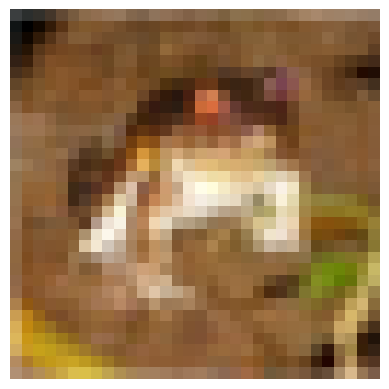

In [29]:
import matplotlib.pyplot as plt

image = train_data[0][0]
plt.imshow(image.permute(1,2,0)) # order in plt should be (height, width, channel)
plt.axis('off')
plt.show()

In [13]:
# Custom Datset

import os
from torch.utils.data import Dataset
import glob
import cv2

class CIFAR10(Dataset):
    def __init__(self, is_train=True, transform=None, path='./DATA'):
        self.classes = 10 
        self.is_train = is_train
        self.transform = transform
        if self.is_train: # train
            self.img_path = glob.glob(os.path.join(path,'train/*/*'))
        else:
            self.img_path = glob.glob(os.path.join(path,'test/*/*'))
        self.label_dict = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4,
                          'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx])
        img = self.transform(img)
        label = self.img_path[idx].split('/')[-2]
        label = self.label_dict[label]
        return img, label

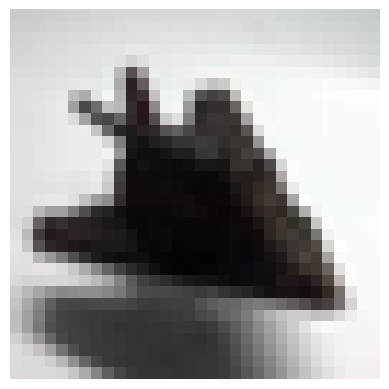

In [27]:
train_data = CIFAR10(
    is_train=True,
    transform=ToTensor(),
    path = root
)

image = train_data[0][0]
plt.imshow(image.permute(1,2,0)) # order in plt should be (height, width, channel)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


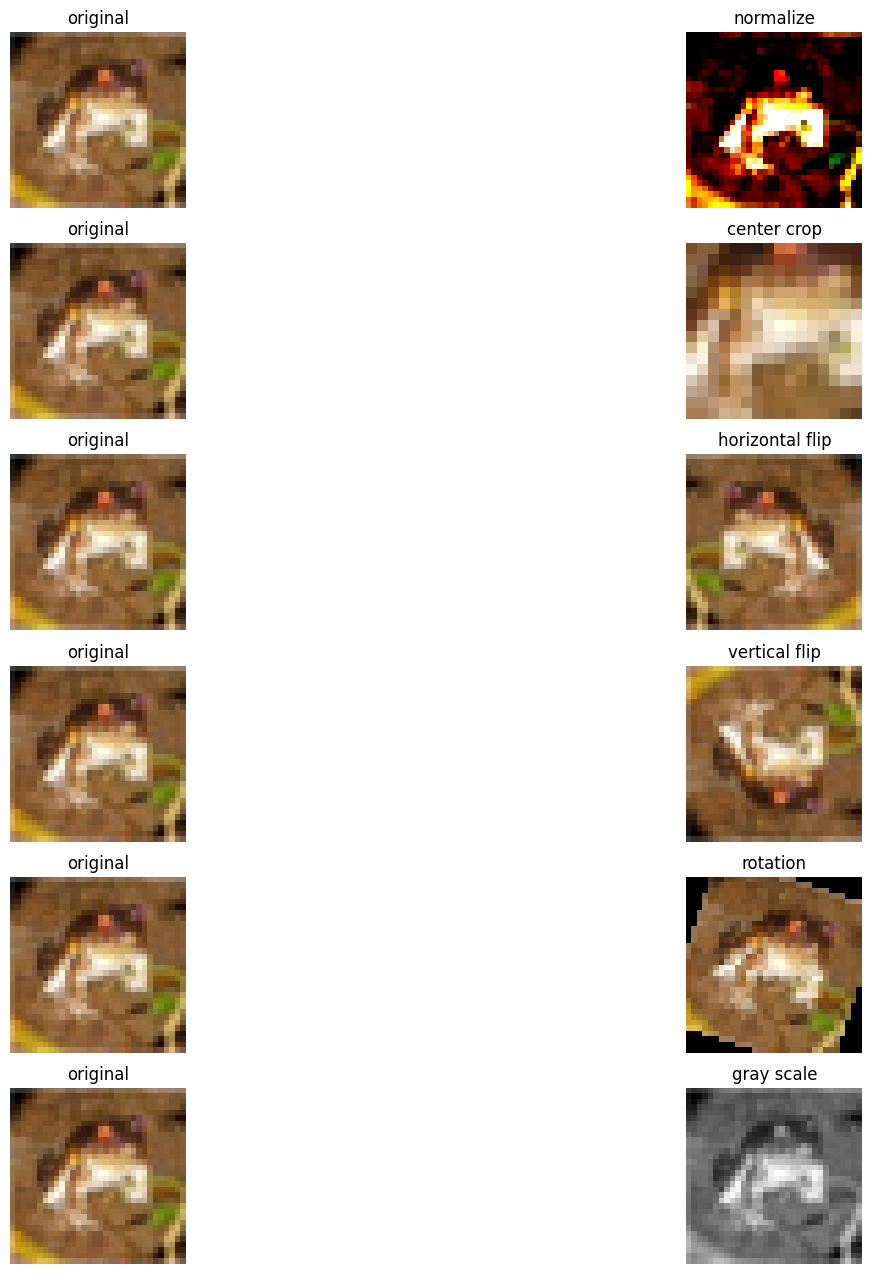

In [41]:
# Augmentations

import torchvision.transforms as transforms


normalize =transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    )
center_crop = transforms.CenterCrop(16)
horizontal_flip = transforms.RandomHorizontalFlip(p=1)
vertical_flip = transforms.RandomVerticalFlip(p=1)
random_roation = transforms.RandomRotation([-45, 45])
gray_scale = transforms.Grayscale()

normalized_img = normalize(image)
center_crop_img = center_crop(image)
h_flip_img = horizontal_flip(image)
v_flip_img = vertical_flip(image)
rotate_img = random_roation(image)
gray_img = gray_scale(image)

fig = plt.figure(figsize=(16,16))

for i in range(1,12,2):
    plt.subplot(6,2,i)
    plt.imshow(image.permute(1,2,0))
    plt.title('original')
    plt.axis('off')

plt.subplot(6,2,2)
plt.imshow(normalized_img.permute(1, 2, 0))
plt.title('normalize')
plt.axis('off')

plt.subplot(6,2,4)
plt.imshow(center_crop_img.permute(1,2,0))
plt.title('center crop')
plt.axis('off')

plt.subplot(6,2,6)
plt.imshow(h_flip_img.permute(1, 2, 0))
plt.title('horizontal flip')
plt.axis('off')

plt.subplot(6,2,8)
plt.imshow(v_flip_img.permute(1, 2, 0))
plt.title('vertical flip')
plt.axis('off')

plt.subplot(6,2,10)
plt.imshow(rotate_img.permute(1, 2, 0))
plt.title('rotation')
plt.axis('off')

plt.subplot(6,2,12)
plt.imshow(gray_img.permute(1, 2, 0), cmap='gray')
plt.title('gray scale')
plt.axis('off')

plt.show()

In [42]:
#Data Loader

from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

In [43]:
data = next(iter(train_dataloader))
print(data[0].shape)

torch.Size([64, 3, 32, 32])
